In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/114_sd_scratch_3/114_sd_scratch_3.ipynb)

# Stable Diffusion desde cero - Parte 3

Seguimos en nuestro viaje aprendiendo sobre Stable Diffusion. Si bien en los posts anteriores hemos aprendido a generar imágenes realistas, éstas eran de una baja resolución. En este post aprendermos como generar imágenes de más alta resolución.

## El Dataset

Para ello vamos a usar un nuevo conjunto de datos. En este caso generaremos imágenes de satélite, y para ello usaremos el dataset [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).

In [2]:
import os 
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
url = "http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip"

# download 
path = Path('./data')
compressed_path = path / "UCMerced_LandUse.zip"
uncompressed_path = path / "UCMerced_LandUse"
if not os.path.isfile(compressed_path):
    print("Downloading dataset...")
    os.makedirs(path, exist_ok=True)
    r = requests.get(url, stream=True)
    with open(compressed_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

# unzip
if not os.path.isdir(uncompressed_path):
    with zipfile.ZipFile(compressed_path) as zf:
        for member in tqdm(zf.infolist(), desc="extracting..."):
            try:
                zf.extract(member, path)
            except zipfile.error as e:
                pass


In [4]:
data_path = uncompressed_path / 'Images'
classes = sorted(os.listdir(data_path))
classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [5]:
images, labels = [], []
for ix, label in enumerate(classes[1:2]):
    _images = os.listdir(data_path / label)
    images += [str(data_path / label / img) for img in _images]
    labels += [ix] * len(_images)
assert len(images) == len(labels)
df = pd.DataFrame({"image": images, "label": labels})

df

,image,label
0,data/UCMerced_LandUse/Images/airplane/airplane...,0
1,data/UCMerced_LandUse/Images/airplane/airplane...,0
2,data/UCMerced_LandUse/Images/airplane/airplane...,0
3,data/UCMerced_LandUse/Images/airplane/airplane...,0
4,data/UCMerced_LandUse/Images/airplane/airplane...,0
...,...,...
95,data/UCMerced_LandUse/Images/airplane/airplane...,0
96,data/UCMerced_LandUse/Images/airplane/airplane...,0
97,data/UCMerced_LandUse/Images/airplane/airplane...,0
98,data/UCMerced_LandUse/Images/airplane/airplane...,0


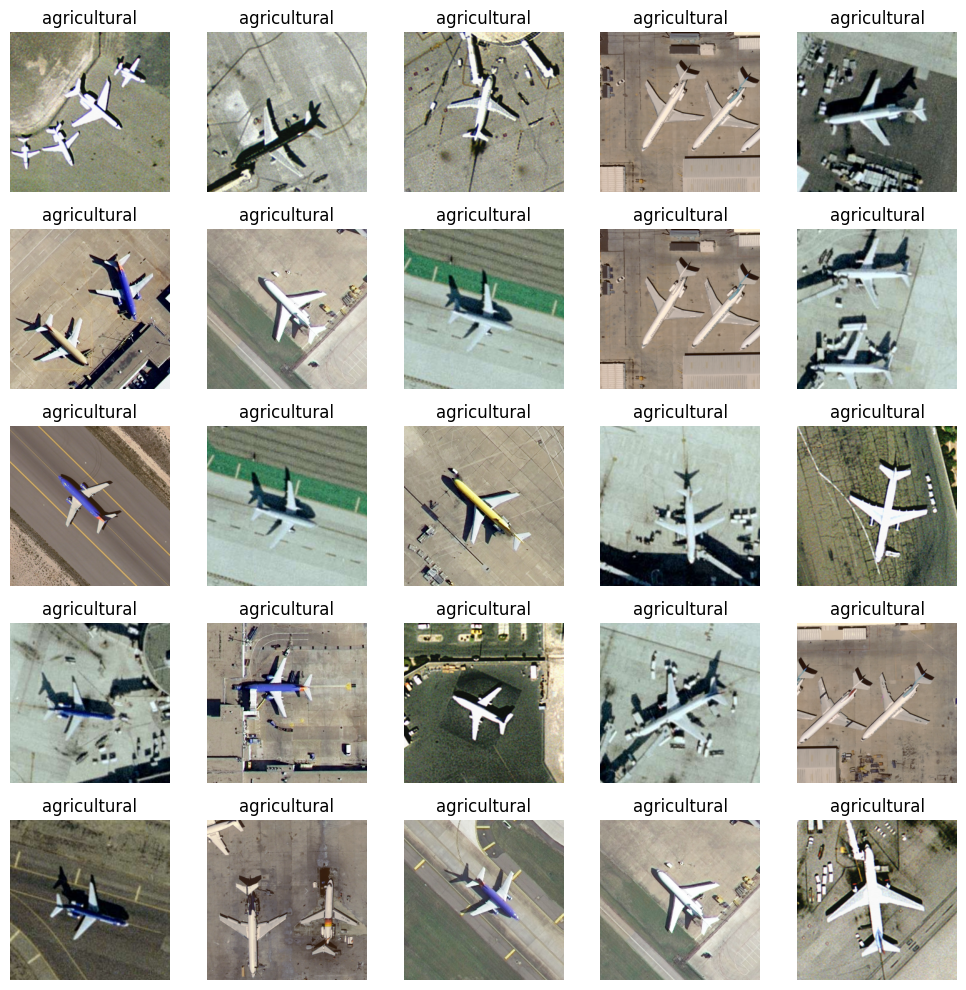

In [6]:
# plot samples

fig = plt.figure(figsize=(10, 10))
r, c = 5, 5
for i in range(1, r * c + 1):
    sample = df.sample(1)
    img = plt.imread(sample.image.values[0])
    fig.add_subplot(r, c, i)
    plt.imshow(img)
    plt.title(classes[sample.label.values[0]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
img.shape, img.dtype, img.min(), img.max()

((256, 256, 3), dtype('uint8'), 12, 250)

## Generando imágenes

Para empezar, vamos a intentar aplicar la misma *pipeline* que en el post anterior.

In [67]:
import torch

def noise_scheduler(start=1e-4, end=0.02, steps=1000):
    betas = torch.linspace(start, end, steps)
    alphas = 1. - betas
    alphas_hat = torch.cumprod(alphas, axis=0)
    return betas, alphas, alphas_hat

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, trans, T=1000):
        self.X = X
        self.y = y
        self.T = T
        self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)
        self.trans = trans

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        im = io.imread(self.X[ix])
        im = self.trans(image=im)["image"]
        t = torch.randint(0, self.T, (1,))
        noise = torch.randn_like(im, dtype=torch.float32) # ruido
        x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
        return x, noise, t, self.y[ix]

In [68]:
from unet import ConditionalDiffusionModel

model = ConditionalDiffusionModel(in_ch=3, out_ch=3, n_classes=len(classes), embed_dim=32)
output = model(torch.randn(10, 3, 256, 256), torch.randint(0, 1000, (10,)), torch.randint(0, len(classes), (10,)))
output.shape

torch.Size([10, 3, 256, 256])

In [72]:
EPOCHS = 1000
BATCH_SIZE = 1

trans = A.Compose([
    # A.CenterCrop(224, 224),
    # A.HorizontalFlip(),
    # A.VerticalFlip(),
    # A.Transpose(),
    A.Normalize(0, 1),    
    A.Lambda(lambda x, **kwargs: 2.*x - 1.),
    ToTensorV2()                                
])
ds = Dataset(df.image.values[:1], df.label.values[:1], trans)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = ConditionalDiffusionModel(in_ch=3, out_ch=3, n_classes=len(classes)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
    losses = []
    pb = tqdm(dl)
    for im, noise, t, y in pb:
        im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda()
        if np.random.rand() < 0.1:
            y = None
        output = model(im, t, y)
        loss = torch.nn.functional.mse_loss(output, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 1000/1000 loss 0.01350: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


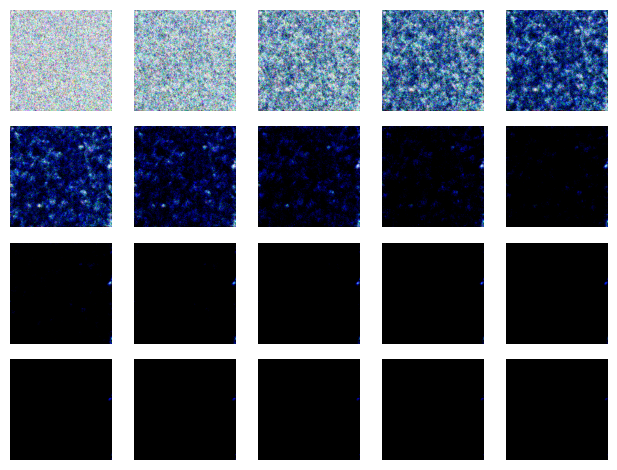

In [73]:
model.eval()

x = torch.randn(1, 3, 256, 256).cuda() # ruido inicial
y = 0 # airplane
cfg = 7.5 # escala del guiado

r, c = 4, 5
fig = plt.figure(dpi=100)
i = 0
for t in reversed(range(ds.T)):
    with torch.no_grad():
        output = model(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
        output_uncond = model(x, torch.tensor([t]).cuda(), None)
        output  = torch.lerp(output_uncond, output, cfg)
    if t > 0:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)
    x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])

    if t % 50 == 0:
        i += 1
        ax = plt.subplot(r, c, i)    
        ax.imshow(np.clip(x[0].permute(1,2,0).cpu().numpy()*0.5 + 1.,0,1))
        ax.axis("off")
plt.tight_layout()
plt.show()

## Mejorando la *performance*

Si bien es posible llevar a cabo la tarea, ésta puede ser muy lenta (más a medida que queramos generar imágenes de mayor resolución). Para ello, los autores de Stable Diffusion proponen entrenar primero un *autoencoder* para luego aplicar la técnica de *diffusion* en el espacio latente (de menor dimensionalidad).

![sd](sd.PNG)

In [15]:
import torch.nn as nn
from torch.nn import Sequential as S
from torch.nn import Conv2d as C
from torch.nn import BatchNorm2d as B
from torch.nn import LeakyReLU as R
from torch.nn import ConvTranspose2d as CT
from torch.nn import Tanh as T
from torch.nn import Linear as L
from torch.nn import AdaptiveAvgPool2d as AP
from torch.nn import Flatten as F
import torch

class Autoencoder(nn.Module):
    def __init__(self, in_ch=3, emb_dim=64, emb_ch=512):
        super().__init__()
        # TODO

In [16]:
vae = VAE() 
output, mu, log_var = vae(torch.randn(1, 3, 256, 256))
output.shape, mu.shape, log_var.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 4096]), torch.Size([1, 4096]))

In [17]:
class DatasetVAE(torch.utils.data.Dataset):
    def __init__(self, X, trans):
        self.X = X
        self.trans = trans

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        im = io.imread(self.X[ix])
        im = self.trans(image=im)["image"]
        return im

In [26]:
EPOCHS = 10
BATCH_SIZE = 16

trans = A.Compose([
    A.PadIfNeeded(256, 256),
    A.CenterCrop(256, 256),
    # A.HorizontalFlip(),
    # A.VerticalFlip(),
    # A.Transpose(),
    A.Normalize(0, 1),    
    A.Lambda(lambda x, **kwargs: 2.*x - 1.),
    ToTensorV2()                                
])
ds = DatasetVAE(df.image.values, trans)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = VAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
    l1, l2 = [], []
    pb = tqdm(dl)
    for im in pb:
        im = im.cuda()
        output, mu, log_var = model(im)
        recons_loss = torch.nn.functional.mse_loss(output, im)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        loss = recons_loss + kld_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l1.append(recons_loss.item())
        l2.append(kld_loss.item())
        pb.set_description(f'Epoch {epoch}/{EPOCHS} recons_loss {np.mean(l1):.5f}' f' kld_loss {np.mean(l2):.5f}')

/home/juan/.local/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1639: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(
Epoch 10/10 recons_loss 0.16596 kld_loss 0.56077: 100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


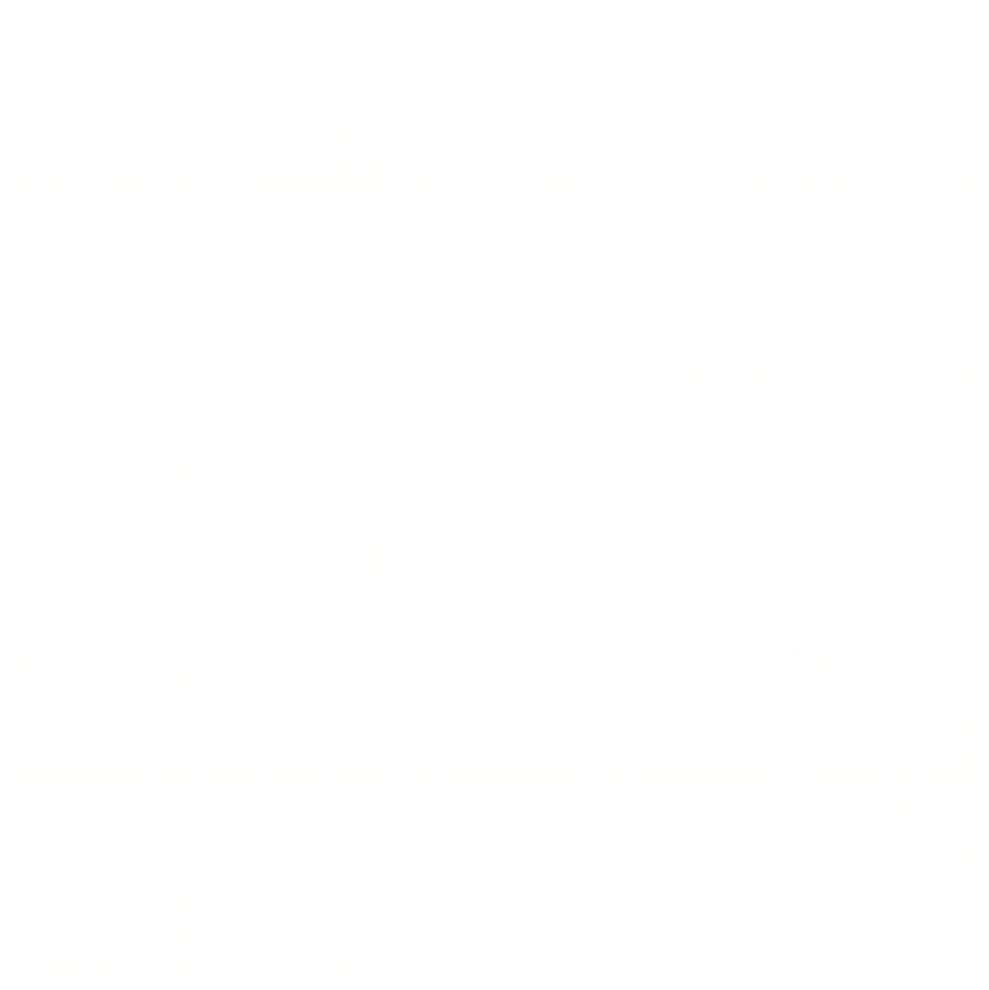

In [27]:
# sampling

model.eval()
with torch.no_grad():
    output = model.sample(25)
    output = output.permute(0, 2, 3, 1).cpu().numpy()

fig = plt.figure(figsize=(10, 10))
r, c = 5, 5
for i in range(r*c):
    ax = plt.subplot(r, c, i+1)
    ax.imshow(np.clip(output[i]*0.5 + 1.,0,1))
    ax.axis("off")
plt.tight_layout()
plt.show()

In [30]:
output.min(), output.max()

(-0.2812404, 0.54398596)